In [1]:
# Connect WRDS
import wrds

db = wrds.Connection(wrds_username='yanqinglin')

Loading library list...
Done


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fsolve
from pandas_datareader import data as pdr
import datetime
import wrds
import warnings
from scipy.optimize import minimize
from scipy.optimize import newton
warnings.filterwarnings('ignore')

Retrieving Barrick Gold's debt data...
=== Quarterly Debt Data (debt_quarterly) ===
             gvkey   dlttq  dlcq            Lt
datadate                                      
2023-12-31  002055  5180.0  43.0  2633000000.0
2024-03-31  002055  4713.0  12.0  2368500000.0
2024-06-30  002055  4713.0  11.0  2367500000.0
2024-09-30  002055  4712.0  13.0  2369000000.0
2024-12-31  002055  5172.0  84.0  2670000000.0

=== Daily Interpolated Debt Data (daily_debt) ===
                           Lt
date                         
2023-12-31       2633000000.0
2024-01-01  2630093406.593407
2024-01-02  2627186813.186813
2024-01-03   2624280219.78022
2024-01-04  2621373626.373626
...                       ...
2024-12-27  2656913043.478261
2024-12-28  2660184782.608696
2024-12-29   2663456521.73913
2024-12-30  2666728260.869565
2024-12-31       2670000000.0

[367 rows x 1 columns]


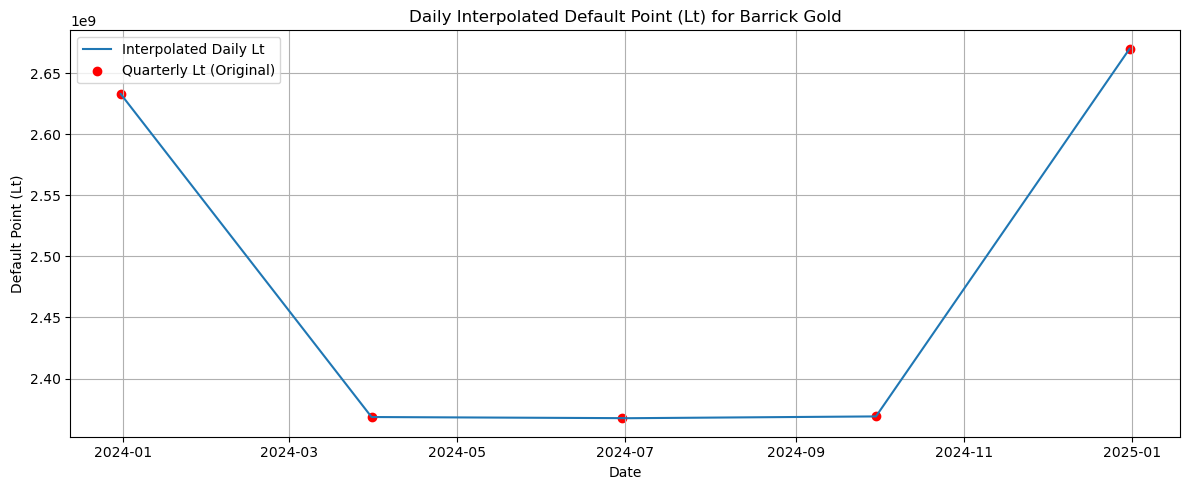

In [3]:
# Question 1
# Retrieve debt data from Compustat for Barrick Gold
print("Retrieving Barrick Gold's debt data...")
query_debt = """
SELECT datadate, gvkey, dlttq, dlcq
FROM comp.fundq
WHERE gvkey = '002055' 
  AND datadate BETWEEN '2023-10-01' AND '2024-12-31'
ORDER BY datadate
"""
debt_quarterly = db.raw_sql(query_debt)

# Convert date column to datetime format
debt_quarterly['datadate'] = pd.to_datetime(debt_quarterly['datadate'])

# Calculate default point Lt as current liabilities + 50% of long-term debt
# dlcq and dlttq are in million USD
debt_quarterly['Lt'] = (debt_quarterly['dlcq'] + 0.5 * debt_quarterly['dlttq']) * 1000000

# Set the date as the index
debt_quarterly.set_index('datadate', inplace=True)

# Create a daily date range covering the period of the available data
daily_dates = pd.date_range(start=debt_quarterly.index.min(), end=debt_quarterly.index.max())
daily_debt = pd.DataFrame(index=daily_dates)

# Join and interpolate quarterly data to get daily values
daily_debt = daily_debt.join(debt_quarterly[['Lt']])
daily_debt = daily_debt.interpolate(method='linear')
daily_debt.index.name = "date"

# Display the original quarterly debt data
print("=== Quarterly Debt Data (debt_quarterly) ===")
print(debt_quarterly)

# Display the interpolated daily debt data
print("\n=== Daily Interpolated Debt Data (daily_debt) ===")
print(daily_debt)

# Plot the interpolated default point over time
plt.figure(figsize=(12, 5))
plt.plot(daily_debt.index, daily_debt['Lt'], label='Interpolated Daily Lt')
plt.scatter(debt_quarterly.index, debt_quarterly['Lt'], color='red', label='Quarterly Lt (Original)')
plt.title('Daily Interpolated Default Point (Lt) for Barrick Gold')
plt.xlabel('Date')
plt.ylabel('Default Point (Lt)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Retrieving Barrick Gold's stock price and shares outstanding...
=== Daily Market Capitalization ===
                    market_cap
date                          
2024-01-02       31397280000.0
2024-01-03  30431479999.999996
2024-01-04  30466600000.000004
2024-01-05  30712439999.999996
2024-01-08  31063640000.000004
...                        ...
2024-12-24       27461849790.0
2024-12-26       27514291260.0
2024-12-27       27409408320.0
2024-12-30       27024837540.0
2024-12-31       27094759500.0

[252 rows x 1 columns]


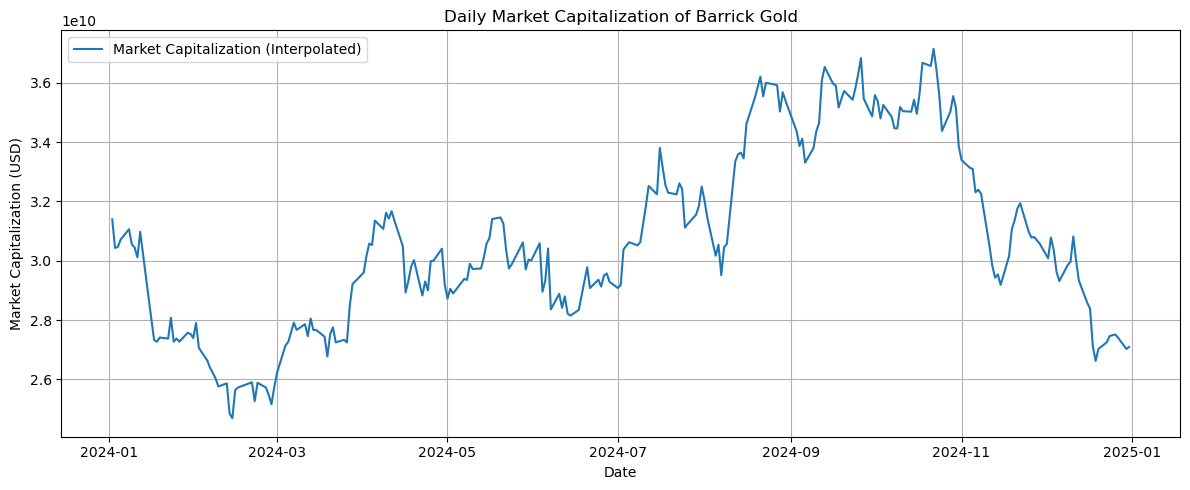

In [4]:
# Question 2
# Get stock price and shares outstanding from CRSP
print("Retrieving Barrick Gold's stock price and shares outstanding...")
query_stock = """
SELECT date, prc, shrout
FROM crsp.dsf
WHERE permno = 71298
  AND date BETWEEN '2023-12-31' AND '2024-12-31'
ORDER BY date
"""
stock_data = db.raw_sql(query_stock)

# Convert date column and clean up
stock_data['date'] = pd.to_datetime(stock_data['date'])
stock_data['prc'] = stock_data['prc'].abs()  # Ensure positive prices
stock_data['shrout'] = stock_data['shrout'] * 1000  # Convert from thousands to shares
stock_data['market_cap'] = stock_data['prc'] * stock_data['shrout']
stock_data.set_index('date', inplace=True)
stock_data = stock_data.sort_index()  # Ensure chronological order

# Keep only market cap
stock_data = stock_data[['market_cap']]

# Print the daily market capitalization after interpolation
print("=== Daily Market Capitalization ===")
print(stock_data)

# Plot the daily market capitalization time series
plt.figure(figsize=(12, 5))
plt.plot(stock_data.index, stock_data['market_cap'], label='Market Capitalization (Interpolated)')
plt.title('Daily Market Capitalization of Barrick Gold')
plt.xlabel('Date')
plt.ylabel('Market Capitalization (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# Question 3
# Retrieve risk-free rate (1-year zero-coupon yield from St. Louis Fed)
print("Fetching 1-year zero-coupon Treasury yield...")

start_date = debt_quarterly.index.min()
end_date = debt_quarterly.index.max()

risk_free_data = pdr.get_data_fred('THREEFY1', start=start_date, end=end_date)
risk_free_data = risk_free_data / 100  # Convert from percentage to decimal
risk_free_data.index = pd.to_datetime(risk_free_data.index)
risk_free_data = risk_free_data.dropna()

print("Successfully retrieved risk-free rate data:")
print(risk_free_data)

Fetching 1-year zero-coupon Treasury yield...
Successfully retrieved risk-free rate data:
            THREEFY1
DATE                
2024-01-02  0.047805
2024-01-03  0.047802
2024-01-04  0.048062
2024-01-05  0.048169
2024-01-08  0.047959
...              ...
2024-12-24  0.043222
2024-12-26  0.043109
2024-12-27  0.043011
2024-12-30  0.042641
2024-12-31  0.042575

[250 rows x 1 columns]


In [6]:
def merton_system(E, L, r, T, sigma_E, tol=1e-8, maxiter=100):
    E = float(E)
    L = float(L)
    r = float(r)
    sigma_E = float(sigma_E)
    sigma_V = sigma_E

    for i in range(maxiter):
        # (1) Given current asset volatility sigma_V, solve for asset value V
        def equity_resid(V):
            d1 = (np.log(V / L) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
            d2 = d1 - sigma_V * np.sqrt(T)
            return V * norm.cdf(d1) - L * np.exp(-r * T) * norm.cdf(d2) - E

        # initial guess: equity + PV of liabilities
        V0 = E + L * np.exp(-r * T)
        V = newton(equity_resid, V0)

        # (2) Update asset volatility from equity-vol mapping
        d1 = (np.log(V / L) + (r + 0.5 * sigma_V**2) * T) / (sigma_V * np.sqrt(T))
        sigma_V_new = sigma_E * E / (V * norm.cdf(d1))

        # (3) Check for convergence in sigma_V
        if abs(sigma_V_new - sigma_V) < tol:
            sigma_V = sigma_V_new
            break
        sigma_V = sigma_V_new

    return V, sigma_V

# ——— Data merging & cleaning ———
# 1) Ensure datetime index and sort chronologically
daily_debt     = daily_debt.sort_index()
stock_data     = stock_data.sort_index()
risk_free_data = risk_free_data.sort_index()

# 2) Concatenate into a single DataFrame
data = pd.concat([
    daily_debt[['Lt']],
    stock_data[['market_cap']],
    risk_free_data.rename(columns={'THREEFY1': 'risk_free_rate'})
], axis=1)

# 3) Drop rows with missing values, starting from the first valid market_cap
data = data.loc[data['market_cap'].first_valid_index():].dropna()

print("=== Combined Daily Data ===")
print(data.head(), "\n", data.tail())

# ——— Compute σ_E and extract 2024‑12‑31 values ———
# 4) Compute daily log‑returns of market cap and take the standard deviation
rets      = np.log(data['market_cap']).diff().dropna()
sigma_E = rets.std()                   # equity volatility (daily)

# 5) Extract end‑of‑2024 scalars
E_2024 = data.loc['2024-12-31', 'market_cap'].item()
L_2024 = data.loc['2024-12-31', 'Lt'].item()
r_2024 = data.loc['2024-12-31', 'risk_free_rate'].item()

# ——— Run Merton model to get V and σ_V ———
V_2024, sigma_V_2024 = merton_system(
    E=E_2024,
    L=L_2024,
    r=r_2024,
    T=1.0,
    sigma_E=sigma_E
)

print(f"Estimated asset value on 2024-12-31: {V_2024:,.2f} USD")
print(f"Estimated daily asset volatility on 2024-12-31: {sigma_V_2024:.2%}")
print(f"Estimated annualized asset volatility on 2024-12-31: {sigma_V_2024 * np.sqrt(252):.2%}")

=== Combined Daily Data ===
                           Lt          market_cap  risk_free_rate
2024-01-02  2627186813.186813       31397280000.0        0.047805
2024-01-03   2624280219.78022  30431479999.999996        0.047802
2024-01-04  2621373626.373626  30466600000.000004        0.048062
2024-01-05  2618467032.967033  30712439999.999996        0.048169
2024-01-08  2609747252.747253  31063640000.000004        0.047959 
                            Lt     market_cap  risk_free_rate
2024-12-24  2647097826.086957  27461849790.0        0.043222
2024-12-26  2653641304.347826  27514291260.0        0.043109
2024-12-27  2656913043.478261  27409408320.0        0.043011
2024-12-30  2666728260.869565  27024837540.0        0.042641
2024-12-31       2670000000.0  27094759500.0        0.042575
Estimated asset value on 2024-12-31: 29,653,470,132.45 USD
Estimated daily asset volatility on 2024-12-31: 1.97%
Estimated annualized asset volatility on 2024-12-31: 31.28%


=== Default Frontier (Quarterly) ===
    Default Point
0    2.538316e+09
1    2.670000e+09
2    2.801684e+09
3    2.933368e+09
4    3.065053e+09
5    3.196737e+09
6    3.328421e+09
7    3.460105e+09
8    3.591789e+09
9    3.723474e+09
10   3.855158e+09
11   3.986842e+09
12   4.118526e+09
13   4.250211e+09
14   4.381895e+09
15   4.513579e+09
16   4.645263e+09
17   4.776947e+09
18   4.908632e+09
19   5.040316e+09
20   5.172000e+09


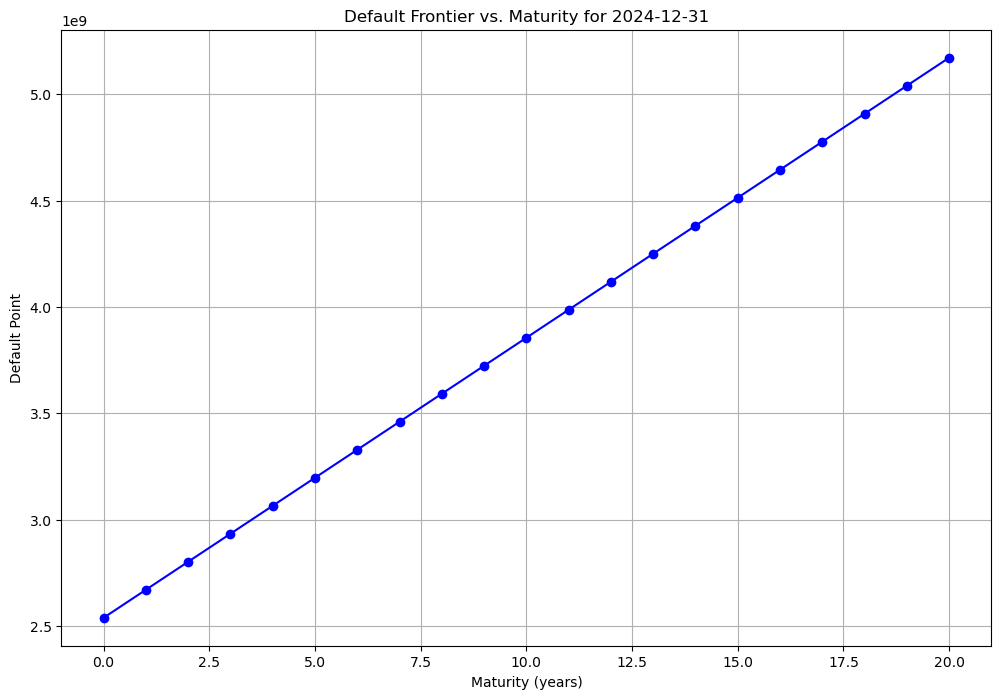

In [7]:
# Question 4
# Data Preparation
lt = debt_quarterly.Lt[-1]  
dlttq = debt_quarterly.dlttq[-1] * 1_000_000  # Convert to the correct scale (dollars)

# Calculate Default Frontier

# Create an array for maturities: from 0 to 20 years (a total of 21 values)
maturities = np.arange(0, 21)

# Calculate the default point for each maturity using vectorized operations
default_points = lt + ((maturities - 1) / (20 - 1)) * (dlttq - lt)

# Construct a DataFrame with the maturities as the index and a single column named "Default Point"
default_frontier_df = pd.DataFrame(default_points, index=maturities, columns=["Default Point"])

# Print the generated DataFrame
print("=== Default Frontier (Quarterly) ===")
print(default_frontier_df)

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(default_frontier_df.index, default_frontier_df["Default Point"], marker='o', color='blue')
plt.title("Default Frontier vs. Maturity for 2024-12-31")
plt.xlabel("Maturity (years)")
plt.ylabel("Default Point")
plt.grid(True)
plt.show()

In [8]:
# Question 5
# Organize the data
# Map each maturity (in years) to its corresponding FRED series code
fred_series = {
    1: "THREEFY1",    # 1-year zero-coupon yield
    2: "THREEFY2",    # 2-year zero-coupon yield
    3: "THREEFY3",    # 3-year zero-coupon yield
    4: "THREEFY4",    # 4-year zero-coupon yield
    5: "THREEFY5",    # 5-year zero-coupon yield
    6: "THREEFY6",    # 6-year zero-coupon yield
    7: "THREEFY7",    # 7-year zero-coupon yield
    8: "THREEFY8",    # 8-year zero-coupon yield
    9: "THREEFY9",    # 9-year zero-coupon yield
    10: "THREEFY10"  # 10-year zero-coupon yield
}

# NSS parameters from St-Louis Fed for 2025-01-02
beta0 = 1.3997809781669e-05
beta1 = 4.17537838746407
beta2 = -124.32776755909
beta3 = 134.379235533314
tau1 = 12.3652373905849
tau2 = 12.9049079240786

def nss_curve(t, beta0, beta1, beta2, beta3, tau1, tau2):
    term1 = beta0
    term2 = beta1 * ((1 - np.exp(-t / tau1)) / (t / tau1))
    term3 = beta2 * (((1 - np.exp(-t / tau1)) / (t / tau1)) - np.exp(-t / tau1))
    term4 = beta3 * (((1 - np.exp(-t / tau2)) / (t / tau2)) - np.exp(-t / tau2))
    return term1 + term2 + term3 + term4

maturities = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
risk_free_yields = nss_curve(maturities, beta0, beta1, beta2, beta3, tau1, tau2)


# Set the target date for which you want to retrieve data
target_date = "2025-01-02" 

# Fetch data for each series from FRED, restricted to the target date
rf_data = {}
for maturity, series in fred_series.items():
    data = pdr.get_data_fred(series, start=target_date, end=target_date)
    if not data.empty:  # Check if any data was returned
        rf_data[maturity] = data[series].iloc[0]
for t in range(11, 21):
    rf_data[t] = nss_curve(t, beta0, beta1, beta2, beta3, tau1, tau2)

rf_data_df = pd.DataFrame.from_dict(rf_data, orient='index', columns=["Yield"])

# Convert the dictionary into a DataFrame for easier viewing
combined_df = default_frontier_df.join(rf_data_df, how='left')
df = combined_df.dropna()

In [9]:
rf_data_df 

,Yield
1,4.249100
2,4.243300
3,4.242500
4,4.258200
5,4.291700
6,4.340500
7,4.401000
8,4.470100
9,4.545000
10,4.623500


=== Term Structure of Credit Spread ===
1     2.844947e-12
2     2.049350e-05
3     3.995459e-03
4     5.600329e-02
5     2.712658e-01
6     7.689758e-01
7     1.601706e+00
8     2.749003e+00
9     4.145400e+00
10    5.709444e+00
11    7.510473e+00
12    9.317083e+00
13    1.114089e+01
14    1.294610e+01
15    1.470777e+01
16    1.640977e+01
17    1.804282e+01
18    1.960274e+01
19    2.108902e+01
20    2.250372e+01
Name: Credit Spread, dtype: float64


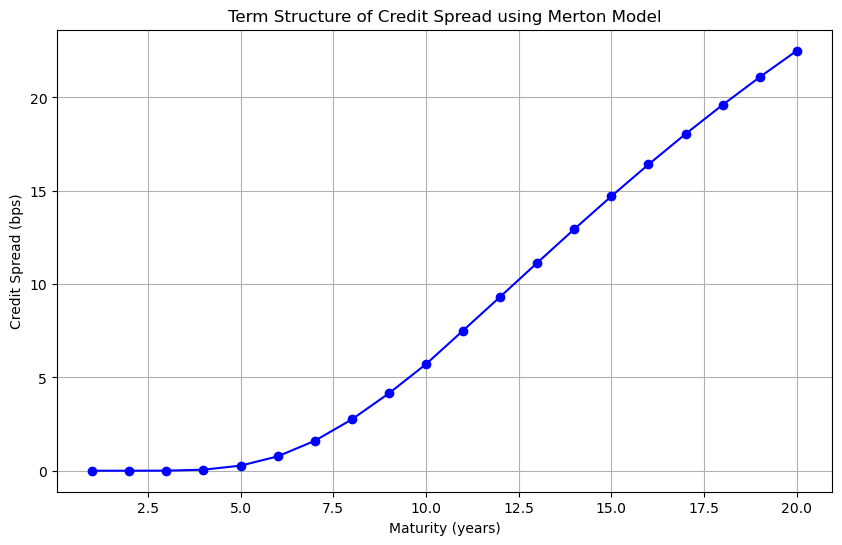

In [10]:
import numpy as np
from scipy.stats import norm
import pandas as pd

# Input Data
# Asset value and volatility on 2024-12-31
v = V_2024
volatility = sigma_V_2024 * np.sqrt(252)
rf = df.Yield / 100
debt = df["Default Point"]

# Select maturities from the debt DataFrame that are >= 1 year
maturities = debt.index[debt.index >= 1]

credit_spreads = []

# Loop over each maturity T to calculate the credit spread
for T in maturities:
    M = debt.loc[T]      # Default boundary (debt level) at this maturity
    r = rf.loc[T]        # Risk-free rate at this maturity
    
    # Calculate d1 and d2 using the Merton model formulas
    d1 = (np.log(v / M) + (r + 0.5 * volatility**2) * T) / (volatility * np.sqrt(T))
    d2 = d1 - volatility * np.sqrt(T)
    
     # Calculate D according to the Merton model
    D = M * np.exp(-r * T) * norm.cdf(d2) + v * norm.cdf(-d1)
    
    # Calculate the credit spread (converted to basis points)
    spread = (-1 / T * np.log(D / M) - r) * 10000
    
    credit_spreads.append(spread)

# Convert the calculated results into a Series with maturities as the index
credit_spread_series = pd.Series(credit_spreads, index=maturities, name="Credit Spread")

# Print the resulting table
print("=== Term Structure of Credit Spread ===")
print(credit_spread_series)

# Plot the term structure of credit spreads
plt.figure(figsize=(10, 6))
plt.plot(credit_spread_series.index, credit_spread_series, marker='o', linestyle='-', color='b')
plt.xlabel("Maturity (years)")
plt.ylabel("Credit Spread (bps)")
plt.title("Term Structure of Credit Spread using Merton Model")
plt.grid(True)
plt.show()

In [11]:
db.close()